# Preparing the dataset for hippocampus segmentation

In this notebook you will use the skills and methods that we have talked about during our EDA Lesson to prepare the hippocampus dataset using Python. Follow the Notebook, writing snippets of code where directed so using Task comments, similar to the one below, which expects you to put the proper imports in place. Write your code directly in the cell with TASK comment. Feel free to add cells as you see fit, but please make sure that code that performs that tasked activity sits in the same cell as the Task comment.


In [1]:
# TASK: Import the following libraries that we will use: nibabel, matplotlib, numpy
import pydicom
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import nibabel as nib

It will help your understanding of the data a lot if you were able to use a tool that allows you to view NIFTI volumes, like [3D Slicer](https://www.slicer.org/). I will refer to Slicer throughout this Notebook and will be pasting some images showing what your output might look like.

## Loading NIFTI images using NiBabel

NiBabel is a python library for working with neuro-imaging formats (including NIFTI) that we have used in some of the exercises throughout the course. Our volumes and labels are in NIFTI format, so we will use nibabel to load and inspect them.

NiBabel documentation could be found here: https://nipy.org/nibabel/

Our dataset sits in two directories - *images* and *labels*. Each image is represented by a single file (we are fortunate to have our data converted to NIFTI) and has a corresponding label file which is named the same as the image file.

Note that our dataset is "dirty". There are a few images and labels that are not quite right. They should be quite obvious to notice, though. The dataset contains an equal amount of "correct" volumes and corresponding labels, and you don't need to alter values of any samples in order to get the clean dataset.

In [2]:
# TASK: Your data sits in directory /data/TrainingSet.
# Load an image and a segmentation mask into variables called image and label

img_nib = nib.load("/data/TrainingSet/images/hippocampus_001.nii.gz")
lbl_nib = nib.load("/data/TrainingSet/labels/hippocampus_001.nii.gz")

In [3]:
image = img_nib.get_fdata()
label = lbl_nib.get_fdata()

In [4]:
image.shape

(35, 51, 35)

In [5]:
label.shape

(35, 51, 35)

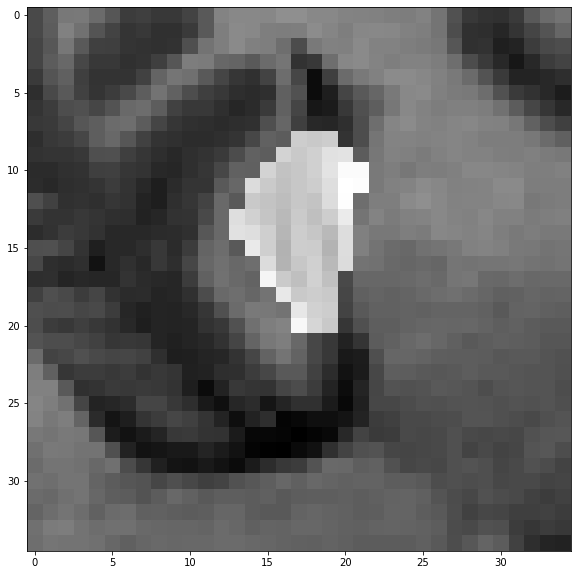

In [6]:
# Nibabel can present your image data as a Numpy array by calling the method get_fdata()
# The array will contain a multi-dimensional Numpy array with numerical values representing voxel intensities. 
# In our case, images and labels are 3-dimensional, so get_fdata will return a 3-dimensional array. You can verify this
# by accessing the .shape attribute. What are the dimensions of the input arrays?

# TASK: using matplotlib, visualize a few slices from the dataset, along with their labels. 
# You can adjust plot sizes like so if you find them too small:
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(image[:,20,:] + label[:,20,:]*50, cmap="gray")

Load volume into 3D Slicer to validate that your visualization is correct and get a feel for the shape of structures.Try to get a visualization like the one below (hint: while Slicer documentation is not particularly great, there are plenty of YouTube videos available! Just look it up on YouTube if you are not sure how to do something)

![3D slicer](img/Slicer.png)

In [7]:
# Stand out suggestion: use one of the simple Volume Rendering algorithms that we've
# implemented in one of our earlier lessons to visualize some of these volumes

## Looking at single image data
In this section we will look closer at the NIFTI representation of our volumes. In order to measure the physical volume of hippocampi, we need to understand the relationship between the sizes of our voxels and the physical world.

In [8]:
# Nibabel supports many imaging formats, NIFTI being just one of them. I told you that our images 
# are in NIFTI, but you should confirm if this is indeed the format that we are dealing with
# TASK: using .header_class attribute - what is the format of our images?

img_header_class = img_nib.header_class
lbl_header_class = lbl_nib.header_class
print(img_header_class)
print(lbl_header_class)

<class 'nibabel.nifti1.Nifti1Header'>
<class 'nibabel.nifti1.Nifti1Header'>


In [9]:
img_header = img_nib.header
lbl_header = lbl_nib.header
print(img_header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 35 51 35  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 1.0
qoffset_y       : 1.0
qoffset_z       : 1.0
srow_x          : [1. 0. 0. 1.]
srow_y          : [0. 

Yep! both are Nifti files

Further down we will be inspecting .header attribute that provides access to NIFTI metadata. You can use this resource as a reference for various fields: https://brainder.org/2012/09/23/the-nifti-file-format/

In [10]:
print("Size of header: "+str(img_nib.header_class.sizeof_hdr))

Size of header: 348


In [14]:
# TASK: How many bits per pixel are used?
print("Bit per pixel: "+str(img_header['bitpix']))

Bit per pixel: 8


In [15]:
# TASK: What are the units of measurement?
int(str(img_header['xyzt_units'].item()), 2)

2

**The unit of measurement is mm (milimeters)**

In [16]:
# TASK: Do we have a regular grid? What are grid spacings?
img_header['pixdim'].tolist()

[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]

In [17]:
img_header['dim']

array([ 3, 35, 51, 35,  1,  1,  1,  1], dtype=int16)

In [18]:
# TASK: What dimensions represent axial, sagittal, and coronal slices? How do you know?

nib.aff2axcodes(img_nib.affine)

('R', 'A', 'S')

In [19]:
np.stack([img_nib.header['srow_x'][:3], img_nib.header['srow_y'][:3], img_nib.header['srow_z'][:3]])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

Based on R.A.S:

* X-axis is Coronal (x-> (R)ight)
* Y-axis is Sagittal (y-> (A)nterior)
* Z-axis is Axial (z-> (S)uperior)

In [20]:
# By now you should have enough information to decide what are dimensions of a single voxel
# TASK: Compute the volume (in mm³) of a hippocampus using one of the labels you've loaded. 
# You should get a number between ~2200 and ~4500

In [21]:
# Lets check how many unique values the labeling data has
set(label.flatten().tolist())

{0.0, 1.0, 2.0}

In [22]:
(label > 0).sum()

2948

To measure the volume of the hippocampus we take the label values. We analyze what type of values we take into consideration. Also, by visualizing it in 3D slicer the image also show us that the 0 values is non-hippocampus area. 1 and 2 values are assigned to hippocampus.

Since we know that we just look for the values that are greater than 0. Which in this case amounts for **2984 mm3**

## Plotting some charts

In [23]:
# TASK: Plot a histogram of all volumes that we have in our dataset and see how 
# our dataset measures against a slice of a normal population represented by the chart below.

In [24]:
# create paths for loop
paths_images = [[os.path.join(root,f) for f in files] for root,dirs,files in os.walk('/data/TrainingSet/images/')][0]
paths_labels = [os.path.join('/data/TrainingSet/labels/', os.path.basename(path)) for path in paths_images]

In [25]:
def get_volume(paths_images, paths_labels):
    fname = os.path.basename(paths_images)
    if not os.path.isfile(paths_images):
        return fname, None
    if not os.path.isfile(paths_labels):
        return fname, None
    
    # load Nifti
    img_nib = nib.load(paths_images)
    lbl_nib = nib.load(paths_labels)

    # transform to numpy.narray
    image = img_nib.get_fdata()
    label = lbl_nib.get_fdata()
    
    pixdim = img_nib.header['pixdim'][1:4].tolist()
    
    vol = (label > 0).sum() * pixdim[0] * pixdim[1] * pixdim[2]
    
    return fname, vol

In [28]:
label_volumes = []
label_fnames = []
none_labels = []
top_outliers = []
bottom_outliers = []

for i in range(len(paths_images)):
    fname, label_volume = get_volume(paths_images[i], paths_labels[i])
    
    if label_volume is not None:
        
        if label_volume < 5000.:
            
            if label_volume > 2499:
                label_volumes.append(label_volume)
                label_fnames.append(fname)
            else:
                bottom_outliers.append(fname)
        else:
            top_outliers.append(fname)
    else:
        none_labels.append(fname)
            
    

In [29]:
#Prints
print('Final number of label volumes: '+str((len(label_volumes))))
print('Final number of label fnames: '+str((len(label_fnames))))
print()
print('None Labes:')
print(none_labels)
print()
print(str(len(top_outliers))+' Top Outliers:')
print(top_outliers)
print()
print(str(len(bottom_outliers))+' Bottom Outliers:')
print(bottom_outliers)

Final number of label volumes: 252
Final number of label fnames: 252

None Labes:
['hippocampus_118.nii.gz']

1 Top Outliers:
['hippocampus_281.nii.gz']

9 Bottom Outliers:
['hippocampus_279.nii.gz', 'hippocampus_225.nii.gz', 'hippocampus_282.nii.gz', 'hippocampus_144.nii.gz', 'hippocampus_143.nii.gz', 'hippocampus_221.nii.gz', 'hippocampus_320.nii.gz', 'hippocampus_319.nii.gz', 'hippocampus_010.nii.gz']


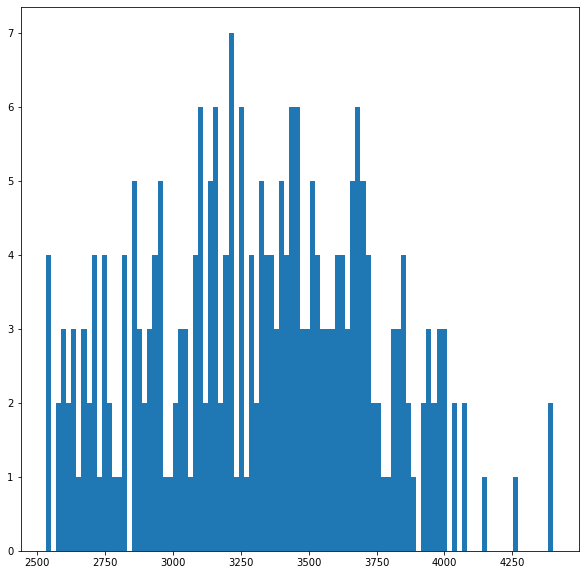

In [30]:
# Plot
plt.hist(label_volumes, bins=100)
plt.show()

<img src="img/nomogram_fem_right.svg" width=400 align=left>

**We notice there is:**

* 1 None existant image
* 1 Top outlier (>5000 mm3)
* 9 Bottom outlier (<2500 mm3)

Do you see any outliers? Why do you think it's so (might be not immediately obvious, but it's always a good idea to inspect) outliers closer. If you haven't found the images that do not belong, the histogram may help you.

In the real world we would have precise information about the ages and conditions of our patients, and understanding how our dataset measures against population norm would be the integral part of clinical validation that we talked about in last lesson. Unfortunately, we do not have this information about this dataset, so we can only guess why it measures the way it is. If you would like to explore further, you can use the [calculator from HippoFit project](http://www.smanohar.com/biobank/calculator.html) to see how our dataset compares against different population slices

Did you notice anything odd about the label files? We hope you did! The mask seems to have two classes, labeled with values `1` and `2` respectively. If you visualized sagittal or axial views, you might have gotten a good guess of what those are. Class 1 is the anterior segment of the hippocampus and class 2 is the posterior one. 

For the purpose of volume calculation we do not care about the distinction, however we will still train our network to differentiate between these two classes and the background

In [31]:
# TASK: Copy the clean dataset to the output folder inside section1/out. You will use it in the next Section

!mkdir -p /home/workspace/out/images
!mkdir -p /home/workspace/out/labels

for i,fname in enumerate(label_fnames):
    !cp {'/data/TrainingSet/images/' + fname} /home/workspace/out/images
    !cp {'/data/TrainingSet/labels/' + fname} /home/workspace/out/labels
    if i % 10 == 0:
        print(f'Files copied: {i}')

Files copied: 0
Files copied: 10
Files copied: 20
Files copied: 30
Files copied: 40
Files copied: 50
Files copied: 60
Files copied: 70
Files copied: 80
Files copied: 90
Files copied: 100
Files copied: 110
Files copied: 120
Files copied: 130
Files copied: 140
Files copied: 150
Files copied: 160
Files copied: 170
Files copied: 180
Files copied: 190
Files copied: 200
Files copied: 210
Files copied: 220
Files copied: 230
Files copied: 240
Files copied: 250


## Final remarks

Congratulations! You have finished Section 1. 

In this section you have inspected a dataset of MRI scans and related segmentations, represented as NIFTI files. We have visualized some slices, and understood the layout of the data. We have inspected file headers to understand what how the image dimensions relate to the physical world and we have understood how to measure our volume. We have then inspected dataset for outliers, and have created a clean set that is ready for consumption by our ML algorithm. 

In the next section you will create training and testing pipelines for a UNet-based machine learning model, run and monitor the execution, and will produce test metrics. This will arm you with all you need to use the model in the clinical context and reason about its performance!